# Deflection Profile Parametric Study
This file presents a parametric study based on the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa.mkappa import MKappa, ReinforcementType
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions, BoundaryConfig
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E 
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement

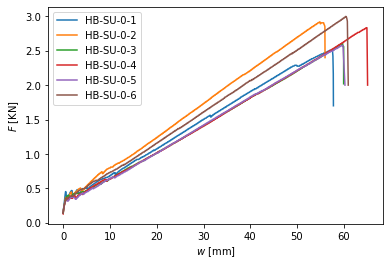

In [4]:
#HB-SU-0
%matplotlib inline
excel_file = join('./verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-0')

for i in range(0,data.shape[1],2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_4= data['HB-SU-0-4_w']  ; f_4= data['HB-SU-0-4_F'] ; validated_data = [w_4, f_4/4]; #plt.plot(w_4,f_4, label = 'HB-SU-0-4')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

In [5]:
def get_parametric_study(parameter_ranges, validated_data):
    
    np.set_printoptions(precision=3)
    if np.ceil(len(parameter_ranges)/3).astype('int') == 1:
        nrows = np.ceil(len(parameter_ranges)/3).astype('int') + 1
    else:
        nrows = np.ceil(len(parameter_ranges)/3).astype('int')
    ncols= 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, 5 * nrows))
    col = 0
    row = 0

    for i, ax in enumerate(axes.flatten()):
        w_val = validated_data[0]
        f_val = validated_data[1]
        ax.plot(w_val, f_val, c= 'black', label= 'Experiment', linestyle='--')
        
    for param_name, param_range in parameter_ranges.items():

        mc = MKappa(n_m=100, n_kappa = 100)
        mc = MKappa(reinforcement_type= ReinforcementType.CARBON)
        dp = DeflectionProfile(mc=mc)
        dp.mc.low_kappa = 0
        dp.mc.high_kappa = 0.0012
        # Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
        dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB

        dp.beam_design.L = 3 * 320
        map_and_assign_params_for_rectangular_section(dp.mc,
                    beta_tu = 20,  #  eps_tu/eps_cr
                    b = 45,
                    h = 30,
                    rho = 7.24/30/150/2,
                    v_f = 1.0,
                    E = 39500,
                    E_s = 240000, 
                    f_sy = 2712 , 
                    eps_cr = 0.000163, 
                    omega = 10.0, #eps_cy/eps_cr
                    psi = 0.0113/0.00016, #eps_sy_j/eps_cr
                    mu = 0.0, #σp/σcr
                    alpha = 0.75, #z_j/h
                    lambda_cu = 20) #eps_cu/eps_cr

        dp.mc.A_j = np.array([3.62, 3.62])  # A_j[0] for tension steel / A_j[1] for compression steel
        dp.mc.z_j = np.array([8, 22])
        dp.mc.E_j = np.array([240000, 240000])
        
        if param_name == 'L':
            for value in np.linspace(*param_range):
                setattr(dp.beam_design, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
        elif param_name == 'B':
            for value in np.linspace(*param_range):
                setattr(dp.mc.cross_section_shape, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
        else:
            for value in np.linspace(*param_range):
                setattr(dp.mc, param_name, value)
                dp.plot_fw_par(axes[row, col], param_name, value)
                
        if col < ncols - 1  :
            col +=1
        else:
            row += 1
            col = 0

No solution The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
No solution The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
No solution The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
No solution The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.


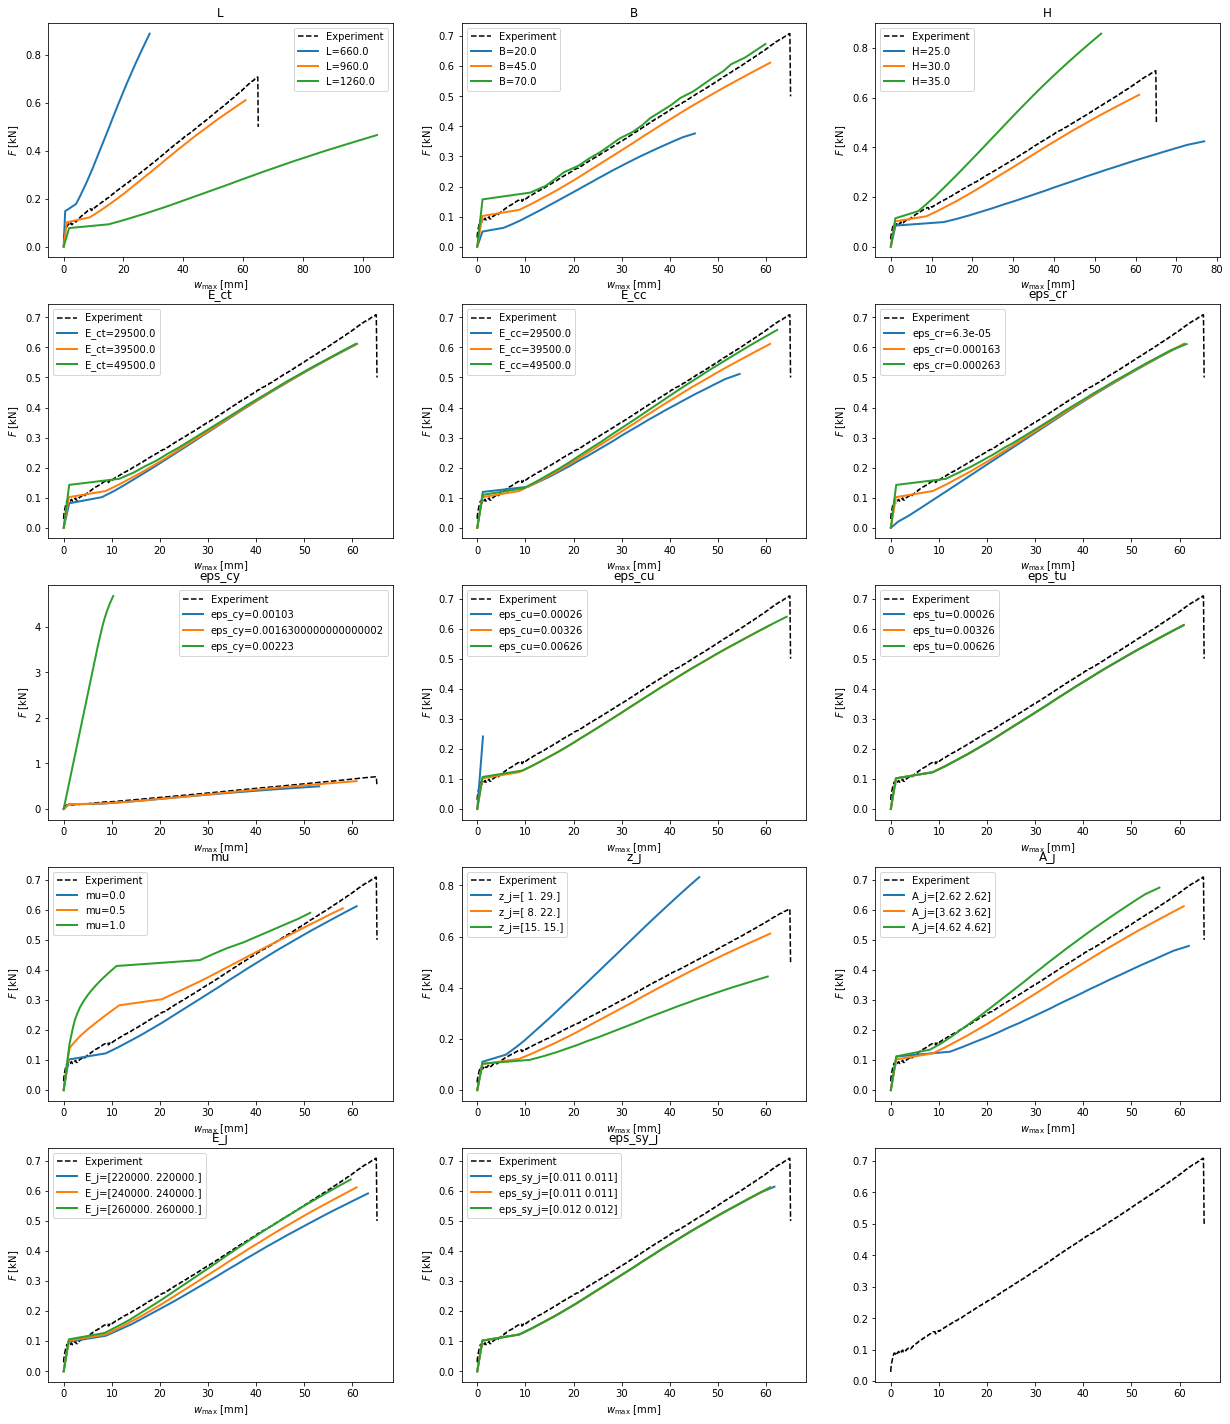

In [6]:
# This dictionary provides the range and number of parameters
n = 3
parameter_ranges = {
        'L' : (660,1260,n),
        'B' : (20,70,n),
        'H': (25,35,n),
        'E_ct': (29500,49500,n),
        'E_cc': (29500,49500,n),
        'eps_cr': (0.000063,0.000263,n),
        'eps_cy': (0.00103,0.00223,n),
        'eps_cu': (0.00026,0.00626,n,int),
        'eps_tu': (0.00026,0.00626,n),
        'mu': (0,1,n),
        'z_j': ([1, 29],[15, 15],n),
        'A_j': ([2.62,2.62],[4.62,4.62],n),
        'E_j': ([220000,220000],[260000,260000], n),
        'eps_sy_j' : ([0.0108,0.0108], [0.0118,0.0118], n),
#         'n_m' : (2, 1000, 10)
    }

ps = get_parametric_study(parameter_ranges, validated_data)
ps